# Segmenting and Clustering Neighborhoods in Toronto

## Toronto - Postal Codes

## Get the wiki page which contains postal codes of 

In [104]:
import requests

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_page = requests.get(url)

## Parse html content

In [105]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(wiki_page.content, 'html.parser')

# soup.children[0] -> <class 'bs4.element.Doctype'>
# soup.children[1] -> <class 'bs4.element.NavigableString'>
# soup.children[2] -> <html>...</html>
html = list(soup.children)[2]

## Extract header information

In [106]:
print(soup.find('title').get_text())

List of postal codes of Canada: M - Wikipedia


## Extract portal codes

In [107]:
# There are 3 tables on the wiki page, however, we only need the first one
table = soup.find('table')
cells = table.findAll('td')
print('Number of cells: ', len(cells))

Number of cells:  180


### Function for parsing content in each cell

In [108]:
import re

pattern = re.compile(r"(?P<code>M\d[A-Z])(?P<borough>[\w\d\s\']+)(?P<nbs>.+)")

def parse(text):
    matches = pattern.search(text)
    code = matches.group('code')
    borough = matches.group('borough')
    nbs = matches.group('nbs')
    if ((borough is not None) and (nbs is None)):
        nbs = borough
    else:
        nbs = re.sub(r'\s+|\)', ' ', nbs)
        nbs = re.sub(r'[\(/]', ', ', nbs)
        nbs = re.sub(r'(^,|,$)', '', nbs)
        nbs = re.sub(r'\s+', ' ', nbs)
    return (code, borough, nbs)

### Loop through all cells, and parse their contents

In [109]:
import pandas as pd

NEG_KEY = 'Not assigned'

pc_dict = {}
pc_dict['PostalCode'] = []
pc_dict['Borough'] = []
pc_dict['Neighborhood'] = []

for cell in cells:
    content = cell.get_text()
    if NEG_KEY in content:
        continue

    code, borough, nbs = parse(content)
    
    pc_dict['PostalCode'].append(code)
    pc_dict['Borough'].append(borough)
    pc_dict['Neighborhood'].append(nbs)

ds = pd.DataFrame(pc_dict, columns=['PostalCode', 'Borough', 'Neighborhood'])
ds.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### Clean-up/Patch

In [110]:
print('Exceptions:')
print(ds[ds['PostalCode'].isin(['M5W', 'M7R', 'M7Y', 'M9W'])])

ds.loc[ds['PostalCode'] == 'M7Y', 'Borough'] = 'East Toronto'
ds.loc[ds['PostalCode'] == 'M7Y', 'Neighborhood'] = 'Business Reply Mail Processing Centre 969 Eastern'

ds.loc[ds['PostalCode'] == 'M7R', 'Borough'] = 'Mississauga'
ds.loc[ds['PostalCode'] == 'M7R', 'Neighborhood'] = 'Canada Post Gateway Processing Centre'

ds.loc[ds['PostalCode'] == 'M5W', 'Borough'] = 'Downtown Toronto'
ds.loc[ds['PostalCode'] == 'M5W', 'Neighborhood'] = 'Stn A PO Boxes 25 The Esplanade'

ds.loc[ds['PostalCode'] == 'M9W', 'Borough'] = 'Etobicoke Northwest'

Exceptions:
    PostalCode                                            Borough  \
76         M7R   MississaugaCanada Post Gateway Processing Centre   
92         M5W     Downtown TorontoStn A PO Boxes25 The Esplanade   
94         M9W                                 EtobicokeNorthwest   
100        M7Y  East TorontoBusiness reply mail Processing Cen...   

                                          Neighborhood  
76                                     Enclave of L4W   
92                                     Enclave of M5E   
94    Clairville , Humberwood , Woodbine Downs , We...  
100                                    Enclave of M4L   


In [111]:
print('After patching')
print(ds[ds['PostalCode'].isin(['M5W', 'M7R', 'M7Y', 'M9W'])])

After patching
    PostalCode              Borough  \
76         M7R          Mississauga   
92         M5W     Downtown Toronto   
94         M9W  Etobicoke Northwest   
100        M7Y         East Toronto   

                                          Neighborhood  
76               Canada Post Gateway Processing Centre  
92                     Stn A PO Boxes 25 The Esplanade  
94    Clairville , Humberwood , Woodbine Downs , We...  
100  Business Reply Mail Processing Centre 969 Eastern  


## Summary

In [112]:
print('Number of rows: ', ds.shape[0])

Number of rows:  103


## Toronto - Neighborhoods' Coordinates

### Download Coordinates' Database

In [113]:
#!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

### Read data from Coordinates' Database File

In [114]:
import pandas as pd
coor_ds = pd.read_csv('Geospatial_Coordinates.csv')
coor_ds.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge Postal Codes' Database with Coordinates' Database

In [115]:
ds = pd.merge(left=ds, right=coor_ds, how='left', left_on='PostalCode', right_on='Postal Code')
ds.drop(['Postal Code'], axis=1, inplace=True)
ds.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Toronto - Neighborhood Clustering

### Filter Neighborhoods in York Area

In [116]:
york_ds = ds[ds['Borough'].apply(lambda x : 'York' in x)].reset_index(drop=True)
york_ds.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills North,43.745906,-79.352188
4,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937


In [117]:
from geopy.geocoders import Nominatim

address = 'York, Toronto, ON, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of York, Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of York, Toronto, ON, Canada are 43.6896191, -79.479188.


In [118]:
import folium

# create map of Manhattan using latitude and longitude values
map_york = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, postal_code in zip(york_ds['Latitude'], york_ds['Longitude'], york_ds['PostalCode']):
    label = folium.Popup(postal_code, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_york)   
    
map_york

### Query Venues' Information in Scarborough from Foursquare

#### Foursquare URL and Credentials

In [119]:
import os
import requests

# Foursquare credentials have been stored in local environment variables
CLIENT_ID = os.environ['FOURSQUARE_CLIENT_ID'] 
CLIENT_SECRET = os.environ['FOURSQUARE_CLIENT_SECRET'] 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}'.format(
            CLIENT_ID,
            CLIENT_SECRET
        )

### Extract Information of Venues in York Area

In [120]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [121]:
# function that query venues'information of all neighborhood in Scarborough
def getNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        parameters = {
            'v':VERSION,
            'll':'{},{}'.format(lat, lng),
            'radius':500,
            'limit':50
        }
            
        # make the GET request
        results = requests.get(url, params=parameters).json()["response"]['groups'][0]['items']
        if (0 >= len(results)):
            print('No venue found around', name, '(', lat, ',', lng, ')!!!')
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [122]:
york_venues = getNearbyVenues(
                names=york_ds['PostalCode'],
                latitudes=york_ds['Latitude'],
                longitudes=york_ds['Longitude']
              )

No venue found around M2L ( 43.7574902 , -79.37471409999999 )!!!


### Overview of Venues in York Area

In [123]:
print('Number of venues:', york_venues.shape[0])
print('Number of unique categories: {}'.format(len(york_venues['Venue Category'].unique())))
print()
print('Snapshot:')
print(york_venues.head())

Number of venues: 286
Number of unique categories: 108

Snapshot:
  PostalCode   Latitude  Longitude                   Venue  Venue Latitude  \
0        M3A  43.753259 -79.329656                     KFC       43.754387   
1        M3A  43.753259 -79.329656         Brookbanks Park       43.751976   
2        M3A  43.753259 -79.329656           Variety Store       43.751974   
3        M4A  43.725882 -79.315572  Victoria Village Arena       43.723481   
4        M4A  43.725882 -79.315572               Portugril       43.725819   

   Venue Longitude         Venue Category  
0       -79.333021   Fast Food Restaurant  
1       -79.332140                   Park  
2       -79.333114      Food & Drink Shop  
3       -79.315635           Hockey Arena  
4       -79.312785  Portuguese Restaurant  


In [124]:
print('Grouped by Postal Code:')
print(york_venues.groupby('PostalCode').count())

Grouped by Postal Code:
            Latitude  Longitude  Venue  Venue Latitude  Venue Longitude  \
PostalCode                                                                
M2H                6          6      6               6                6   
M2J               50         50     50              50               50   
M2K                4          4      4               4                4   
M2M                1          1      1               1                1   
M2N               28         28     28              28               28   
M2P                2          2      2               2                2   
M2R                5          5      5               5                5   
M3A                3          3      3               3                3   
M3B                5          5      5               5                5   
M3C               16         16     16              16               16   
M3H               15         15     15              15               15   
M

### Prepare Data for Clustering

In [125]:
# one hot encoding
york_onehot = pd.get_dummies(york_venues[['Venue Category']], prefix="", prefix_sep="")

# add postalcode column back to dataframe
york_onehot['PostalCode'] = york_venues['PostalCode'] 

# move postalcode column to the first column
fixed_columns = [york_onehot.columns[-1]] + list(york_onehot.columns[:-1])
york_onehot = york_onehot[fixed_columns]

print('Encoded dimensions:', york_onehot.shape)
york_onehot.head()

Encoded dimensions: (286, 109)


,PostalCode,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
york_grouped = york_onehot.groupby('PostalCode').mean().reset_index()
print('Grouped dimensions:', york_grouped.shape)
york_grouped.head()

Grouped dimensions: (33, 109)


,PostalCode,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,M2H,0.00,0.0,0.00,0.0,0.000000,0.00,0.166667,0.00,0.000000,...,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.0,0.00,0.0
1,M2J,0.02,0.0,0.02,0.0,0.000000,0.02,0.000000,0.02,0.040000,...,0.0,0.02,0.04,0.0,0.02,0.0,0.000000,0.0,0.02,0.0
2,M2K,0.00,0.0,0.00,0.0,0.000000,0.00,0.000000,0.00,0.250000,...,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.0,0.00,0.0
3,M2M,0.00,0.0,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.0,0.00,0.0
4,M2N,0.00,0.0,0.00,0.0,0.035714,0.00,0.000000,0.00,0.035714,...,0.0,0.00,0.00,0.0,0.00,0.0,0.035714,0.0,0.00,0.0


#### Most common venue categories in each area

In [127]:
num_top_venues = 5

for hood in york_grouped['PostalCode']:
    print("----"+hood+"----")
    temp = york_grouped[york_grouped['PostalCode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M2H----
                  venue  freq
0  Fast Food Restaurant  0.17
1           Golf Course  0.17
2                  Pool  0.17
3    Athletics & Sports  0.17
4               Dog Run  0.17


----M2J----
                  venue  freq
0        Clothing Store  0.18
1           Coffee Shop  0.10
2  Fast Food Restaurant  0.06
3      Toy / Game Store  0.04
4            Restaurant  0.04


----M2K----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3  Japanese Restaurant  0.25
4    Accessories Store  0.00


----M2M----
               venue  freq
0               Park   1.0
1  Accessories Store   0.0
2  Korean Restaurant   0.0
3          Pet Store   0.0
4  Other Repair Shop   0.0


----M2N----
                 venue  freq
0          Coffee Shop  0.14
1     Ramen Restaurant  0.11
2          Pizza Place  0.07
3     Sushi Restaurant  0.07
4  Japanese Restaurant  0.07


----M2P----
               venue  freq
0  Convenience Store 

#### Function to sort venues' categories in each area

In [128]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Scan through all areas

In [129]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
areas_venues_sorted = pd.DataFrame(columns=columns)
areas_venues_sorted['PostalCode'] = york_grouped['PostalCode']

for ind in np.arange(york_grouped.shape[0]):
    areas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(york_grouped.iloc[ind, :], num_top_venues)

areas_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2H,Dog Run,Golf Course,Pool,Athletics & Sports,Fast Food Restaurant,Mediterranean Restaurant,Diner,Convenience Store,Cosmetics Shop,Curling Ice
1,M2J,Clothing Store,Coffee Shop,Fast Food Restaurant,Toy / Game Store,Bank,Restaurant,Department Store,Women's Store,Gift Shop,Pharmacy
2,M2K,Japanese Restaurant,Chinese Restaurant,Café,Bank,Yoga Studio,Cosmetics Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store
3,M2M,Park,Yoga Studio,Discount Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store
4,M2N,Coffee Shop,Ramen Restaurant,Sushi Restaurant,Pizza Place,Japanese Restaurant,Grocery Store,Ice Cream Shop,Restaurant,Sandwich Place,Shopping Mall


### Cluster Areas based-on their Venues' Categories

#### Determine the relattion between number of clusters and clustering performances

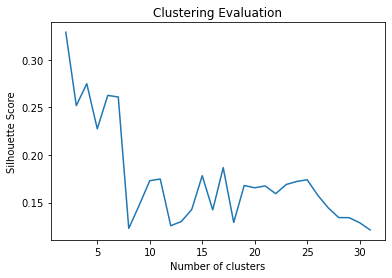

In [130]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

york_grouped_clustering = york_grouped.drop('PostalCode', 1)

cluster_numbers = list(range(2, 32))
scores = []
for n in cluster_numbers:
    # run k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0).fit(york_grouped_clustering)
    scores.append(silhouette_score(york_grouped_clustering, kmeans.labels_, metric='euclidean'))

fig, ax = plt.subplots()
ax.plot(cluster_numbers, scores)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title("Clustering Evaluation")

plt.show()

#### Let's go with six clusters

In [131]:
# set number of clusters
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(york_grouped_clustering)

#### Merge venues' information with clustering results

In [132]:
# add clustering labels
areas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

york_merged = york_ds

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
york_merged = york_merged.join(areas_venues_sorted.set_index('PostalCode'), on='PostalCode')
york_merged.drop(york_merged[york_merged['Cluster Labels'].isnull()].index, inplace=True)
york_merged['Cluster Labels'] = york_merged['Cluster Labels'].astype('int32')

york_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4,Park,Food & Drink Shop,Fast Food Restaurant,Yoga Studio,Diner,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Dance Studio
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Coffee Shop,Nail Salon,Portuguese Restaurant,Grocery Store,Hockey Arena,Discount Store,Convenience Store,Cosmetics Shop,Curling Ice,Dance Studio
2,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Boutique,Miscellaneous Shop,Coffee Shop,Furniture / Home Store,Accessories Store,Vietnamese Restaurant,Arts & Crafts Store,Dog Run,Curling Ice
3,M3B,North York,Don Mills North,43.745906,-79.352188,1,Japanese Restaurant,Caribbean Restaurant,Café,Gym,Baseball Field,Yoga Studio,Cosmetics Shop,Curling Ice,Dance Studio,Deli / Bodega
4,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937,1,Pizza Place,Bank,Intersection,Gastropub,Pharmacy,Flea Market,Athletics & Sports,Gym / Fitness Center,Dance Studio,Dessert Shop


#### Visualize clusters

In [133]:
from matplotlib import cm, colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(york_merged['Latitude'], york_merged['Longitude'], york_merged['Neighborhood'], york_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

In [138]:
for n in range(kclusters):
    print('Cluster', n)
    print(york_merged.loc[york_merged['Cluster Labels'] == n, york_merged.columns[[1] + list(range(5, york_merged.shape[1]))]])
    print('---------- ---------- ---------- ---------- ----------')
    print()

Cluster 0
       Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
22  North York               0                   Gym            Restaurant   

   3rd Most Common Venue 4th Most Common Venue       5th Most Common Venue  \
22           Yoga Studio        Discount Store  Construction & Landscaping   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
22     Convenience Store        Cosmetics Shop           Curling Ice   

   9th Most Common Venue 10th Most Common Venue  
22          Dance Studio          Deli / Bodega  
---------- ---------- ---------- ---------- ----------

Cluster 1
       Borough  Cluster Labels       1st Most Common Venue  \
1   North York               1                 Coffee Shop   
2   North York               1              Clothing Store   
3   North York               1         Japanese Restaurant   
4    East York               1                 Pizza Place   
5   North York               1          Italian Restaur